Multi-Driver Grand Prix Telemetry Analysis

This notebook engineers telemetry data from the Fast-F1 API for telemetry dataframes for multiple drivers. It utilizes a structured workflow for data acquisition, preparation, and further exploration prior to applying machine learning models to multi-driver behavior analysis results. Additional descriptive statistics are added to single driver data frames that will then be concatenated and used as input for machine learning models.

NOTE: This notebook will not compile as standalone. Please pull down the project from GitHub (git clone https://github.com/yourusername/f1-driving-style-analytics-tool.git) and install the necessary dependencies. Further instruction is included in the README.md

The code below adds the parent directory to Python’s module search path and configures logging to suppress all FastF1 logs below the warning level. This will enable subsequent code blocks that use imports to work seamlessly and keep my resulting code compilations clean and easy to read.

In [1]:
import sys
import os
import logging

root = os.path.abspath("..")
sys.path.append(root)

logging.getLogger('fastf1').setLevel(logging.ERROR)

In this section, I import Python libraries for data visualization, numerical analysis, and working with the Pandas dataframes that the FastF1 API is primarily structured with. I also import custom functions and modules for preprocessing F1 data and constants. To support full visibility into the datasets without truncation, I configure Pandas display options to show all rows and columns.

In [2]:
from src.data import f1_data
from src.utils import f1_constants, f1_pandas_helpers
from src.preprocessing import telemetry_cleaning, feature_engineering, telemetry_processing
from src.viz import plots

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)  # reset_option to compact dataframe view
pd.set_option('display.max_columns', None)


The following code initializes a single F1 race session by defining parameters such as year, location, and session type. These values are passed into the custom F1Session class (from f1_data.py), which creates a session object built on top of Fast-F1. This object provides access to race data as well as custom functions I’ve implemented.

These session parameters were chosen to best match Tier 2 controls:

- Location: Bahrain (clear, windy conditions)
- Green Flag Laps: Remove safety car and VSC distortions
- Single-compound Windows: Avoid mixed group comparisons
- Minimize Outliers: Tire age approx. 20 laps
- Traffic: Avoid slipstream bias (lead >2s ahead)
- Corner Analysis → Isolates driver techniques

In [3]:
year = 2025
grand_prix = f1_constants.F1Constants.LOCATIONS["Bahrain"]
session_type = f1_constants.F1Constants.SESSIONS["R"]

safety_car_laps = [32, 33, 34, 35]

session = f1_data.F1Session(year, grand_prix, session_type)

req         WARNING 	DEFAULT CACHE ENABLED! (1.03 GB) /Users/phillipsmith/Library/Caches/fastf1


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '14', '30', '18', '5', '55', '27']


All drivers who participated in the specific location's Grand Prix will be analyzed and assigned variables to be identified by their three-letter name code.

Constants for telemetry data is also initialized as variables for ease of use during visualization.

Sector timestamps variables are set for easy replacment during telemetry filtering.

In [4]:
# driver constants
piastri = f1_constants.F1Constants.DRIVERS["Oscar Piastri"]
russell = f1_constants.F1Constants.DRIVERS["George Russell"]
norris = f1_constants.F1Constants.DRIVERS["Lando Norris"]
leclerc = f1_constants.F1Constants.DRIVERS["Charles Leclerc"]
hamilton = f1_constants.F1Constants.DRIVERS["Lewis Hamilton"]
verstappen = f1_constants.F1Constants.DRIVERS["Max Verstappen"]
gasly = f1_constants.F1Constants.DRIVERS["Pierre Gasly"]
ocon = f1_constants.F1Constants.DRIVERS["Esteban Ocon"]
tsunoda = f1_constants.F1Constants.DRIVERS["Yuki Tsunoda"]
bearman = f1_constants.F1Constants.DRIVERS["Oliver Bearman"]
antonelli = f1_constants.F1Constants.DRIVERS["Andrea Kimi Antonelli"]
albon = f1_constants.F1Constants.DRIVERS["Alexander Albon"]
hadjar = f1_constants.F1Constants.DRIVERS["Isack Hadjar"]
doohan = f1_constants.F1Constants.DRIVERS["Jack Doohan"]
alonso = f1_constants.F1Constants.DRIVERS["Fernando Alonso"]
lawson = f1_constants.F1Constants.DRIVERS["Liam Lawson"]
stroll = f1_constants.F1Constants.DRIVERS["Lance Stroll"]
bortoleto = f1_constants.F1Constants.DRIVERS["Gabriel Bortoleto"]
sainz = f1_constants.F1Constants.DRIVERS["Carlos Sainz"]
hulkenberg = f1_constants.F1Constants.DRIVERS["Nico Hulkenberg"]

# telemetry constants
speed = f1_constants.F1Constants.TELEMETRY_COLUMNS["Speed (m/s)"]
acceleration = f1_constants.F1Constants.TELEMETRY_COLUMNS["Acceleration (m/s²)"]
jerk = f1_constants.F1Constants.TELEMETRY_COLUMNS["Jerk (m/s³)"]
rpm = f1_constants.F1Constants.TELEMETRY_COLUMNS["RPM"]
g_force = f1_constants.F1Constants.TELEMETRY_COLUMNS["G-force (g)"]
gear = f1_constants.F1Constants.TELEMETRY_COLUMNS["nGear"]
throttle = f1_constants.F1Constants.TELEMETRY_COLUMNS["Throttle (%)"]
brakes = f1_constants.F1Constants.TELEMETRY_COLUMNS["BrakesApplied"]
# steering = f1_constants.F1Constants.TELEMETRY_COLUMNS["Steering Wheel Angle (°)"]

# sector timestamp variables
s1_start = 'Sector1Start'
s1_end_s2_start = 'Sector1End_Sector2Start'
s2_end_s3_start = 'Sector2End_Sector3Start'
s3_end = 'Sector3End'

The code below retrieves circuit information for the session’s corners. The `critical_turn` array identifies corners where driver behavior is especially important for sector and overall lap performance. Adjusting the `radius` value controls how much telemetry around each turn is included, allowing you to visualize throttle and braking traces at the desired level of detail.

In [5]:
corner_position = session.get_circuit_info().corners
corner_position_cleaned = telemetry_cleaning.clean_circuit_corner_data(corner_position)

critical_turn = [10]
radius = 2500

Gather, clean, and enrich each drivers' list of telemetry dataframes for their valid laps.

Each telemetry dataframe is filtered by turn to focus on the most informative segments for analyzing driver behavior and technique at brake-intensive areas.

Lando Norris Race Telemetry & Performance Metrics

In [6]:
norris_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=norris,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Lando Norris Fastest Lap Telemetry for Visualization

In [7]:
norris_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=norris_processed_data,
    driver_code=norris,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Oscar Piastri Race Telemetry & Performance Metrics

In [8]:
piastri_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=piastri,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Oscar Piastri Fastest Lap Telemetry for Visualization

In [9]:
piastri_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=piastri_processed_data,
    driver_code=piastri,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

George Russell Race Telemetry & Performance Metrics

In [10]:
russell_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=russell,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

George Russell Fastest Lap Telemetry for Visualization

In [11]:
russell_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=russell_processed_data,
    driver_code=russell,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Charles Leclerc Race Telemetry & Performance Metrics

In [12]:
leclerc_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=leclerc,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Charles Leclerc Fastest Lap Telemetry for Visualization

In [13]:
leclerc_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=leclerc_processed_data,
    driver_code=leclerc,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Lewis Hamilton Race Telemetry & Performance Metrics

In [14]:
hamilton_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=hamilton,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Lewis Hamilton Fastest Lap Telemetry for Visualization

In [15]:
hamilton_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=hamilton_processed_data,
    driver_code=hamilton,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Max Verstappen Race Telemetry & Performance Metrics

In [16]:
verstappen_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=verstappen,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Max Verstappen Fastest Lap Telemetry for Visualization

In [17]:
verstappen_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=verstappen_processed_data,
    driver_code=verstappen,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Pierre Gasly Race Telemetry & Performance Metrics

In [18]:
gasly_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=gasly,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Pierre Gasly Fastest Lap Telemetry for Visualization

In [19]:
gasly_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=gasly_processed_data,
    driver_code=gasly,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Esteban Ocon Race Telemetry & Performance Metrics

In [20]:
ocon_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=ocon,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Esteban Ocon Fastest Lap Telemetry for Visualization

In [21]:
ocon_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=ocon_processed_data,
    driver_code=ocon,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Yuki Tsunoda Race Telemetry & Performance Metrics

In [22]:
tsunoda_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=tsunoda,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Yuki Tsunoda Fastest Lap Telemetry for Visualization

In [23]:
tsunoda_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=tsunoda_processed_data,
    driver_code=tsunoda,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Oliver Bearman Race Telemetry & Performance Metrics

In [24]:
bearman_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=bearman,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Oliver Bearman Fastest Lap Telemetry for Visualization

In [25]:
bearman_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=bearman_processed_data,
    driver_code=bearman,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Andrea Kimi Antonelli Race Telemetry & Performance Metrics

In [26]:
antonelli_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=antonelli,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Andrea Kimi Antonelli Fastest Lap Telemetry for Visualization

In [27]:
antonelli_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=antonelli_processed_data,
    driver_code=antonelli,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Alexander Albon Race Telemetry & Performance Metrics

In [28]:
albon_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=albon,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Alexander Albon Fastest Lap Telemetry for Visualization

In [29]:
albon_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=albon_processed_data,
    driver_code=albon,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Isack Hadjar Race Telemetry & Performance Metrics

In [30]:
hadjar_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=hadjar,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Isack Hadjar Fastest Lap Telemetry for Visualization

In [31]:
hadjar_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=hadjar_processed_data,
    driver_code=hadjar,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Jack Doohan Race Telemetry & Performance Metrics

In [32]:
doohan_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=doohan,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Jack Doohan Fastest Lap Telemetry for Visualization

In [33]:
doohan_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=doohan_processed_data,
    driver_code=doohan,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Fernando Alonso Race Telemetry & Performance Metrics

In [34]:
alonso_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=alonso,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Fernando Alonso Fastest Lap Telemetry for Visualization

In [35]:
alonso_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=alonso_processed_data,
    driver_code=alonso,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Liam Lawson Race Telemetry & Performance Metrics

In [36]:
lawson_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=lawson,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Liam Lawson Fastest Lap Telemetry for Visualization

In [37]:
lawson_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=lawson_processed_data,
    driver_code=lawson,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Lance Stroll Race Telemetry & Performance Metrics

In [38]:
stroll_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=stroll,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Lance Stroll Fastest Lap Telemetry for Visualization

In [39]:
stroll_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=stroll_processed_data,
    driver_code=stroll,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Gabriel Bortoleto Race Telemetry & Performance Metrics

In [40]:
bortoleto_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=bortoleto,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Gabriel Bortoleto Fastest Lap Telemetry for Visualization

In [41]:
bortoleto_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=bortoleto_processed_data,
    driver_code=bortoleto,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Carlos Sainz Race Telemetry & Performance Metrics

In [42]:
sainz_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=sainz,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Carlos Sainz Fastest Lap Telemetry for Visualization

In [43]:
sainz_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=sainz_processed_data,
    driver_code=sainz,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Nico Hulkenberg Race Telemetry & Performance Metrics

In [44]:
hulkenberg_processed_data = telemetry_processing.process_driver_telemetry(
    session=session,
    driver=hulkenberg,
    safety_car_laps=safety_car_laps,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Nico Hulkenberg Fastest Lap Telemetry for Visualization

In [45]:
hulkenberg_corner_telemetry_enriched = telemetry_processing.get_fastest_lap_corner_telemetry(
    processed_driver_data=hulkenberg_processed_data,
    driver_code=hulkenberg,
    corner_position=corner_position_cleaned,
    critical_turn=critical_turn[0],
    radius=radius,
    start=s1_end_s2_start,
    end=s2_end_s3_start
)

Visualizations - Multiple Drivers - This multi-axis plot can dynamically display telemetry data to reveal unique driver performance for given driver dataframes.
Limit the number of features and drivers to maintain clarity.

Plot all listed drivers' fastest lap telemetry for a given corner.

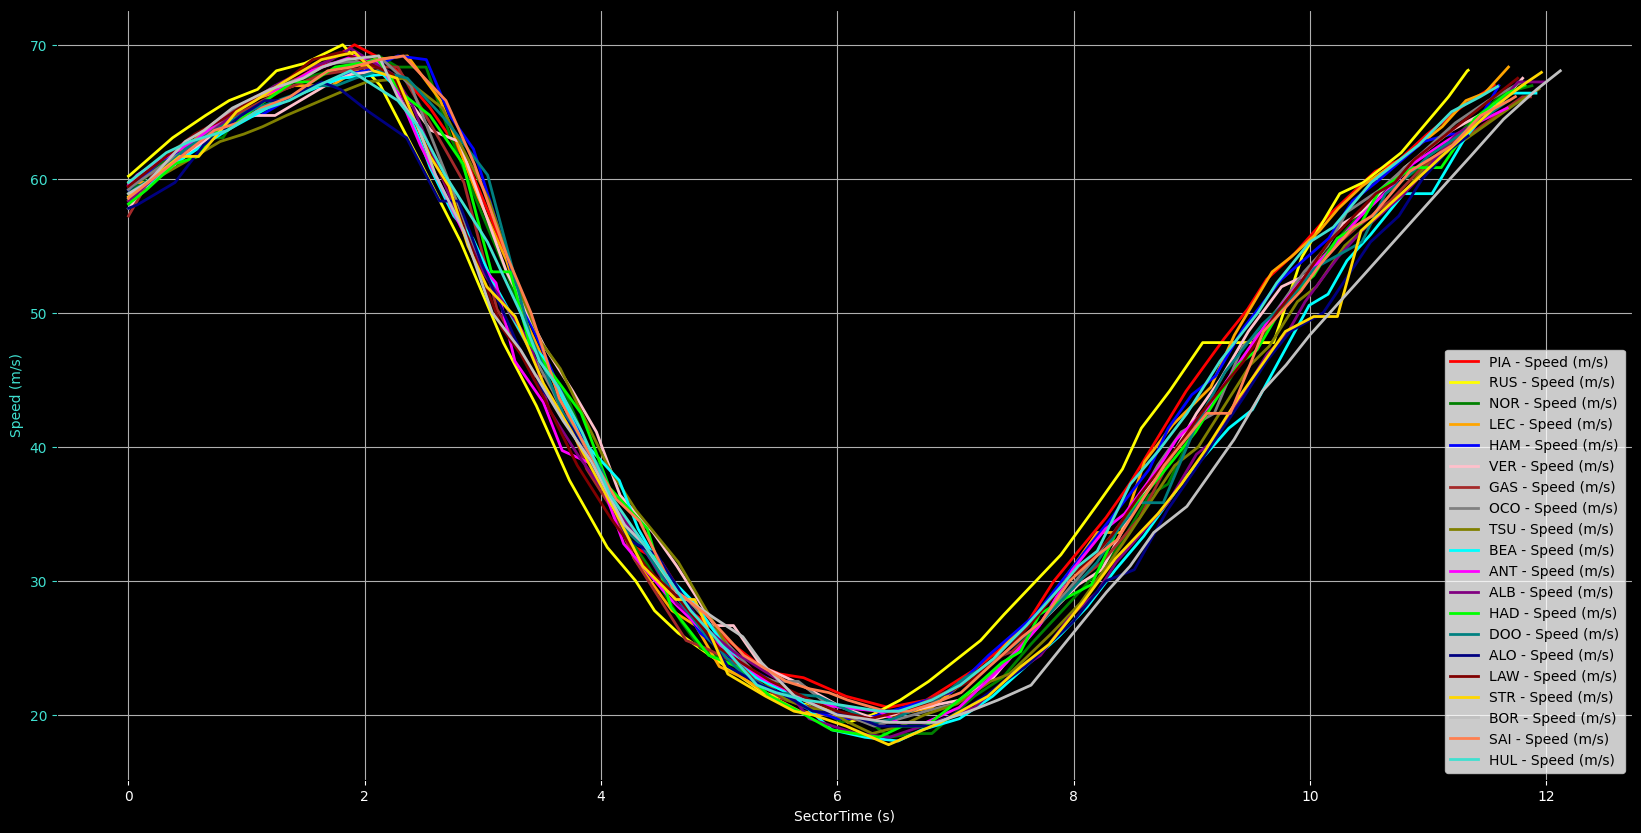

In [46]:
plots.plot_multiple_drivers_telemetry(
    dfs=[
        piastri_corner_telemetry_enriched,
        russell_corner_telemetry_enriched,
        norris_corner_telemetry_enriched,
        leclerc_corner_telemetry_enriched,
        hamilton_corner_telemetry_enriched,
        verstappen_corner_telemetry_enriched,
        gasly_corner_telemetry_enriched,
        ocon_corner_telemetry_enriched,
        tsunoda_corner_telemetry_enriched,
        bearman_corner_telemetry_enriched,
        antonelli_corner_telemetry_enriched,
        albon_corner_telemetry_enriched,
        hadjar_corner_telemetry_enriched,
        doohan_corner_telemetry_enriched,
        alonso_corner_telemetry_enriched,
        lawson_corner_telemetry_enriched,
        stroll_corner_telemetry_enriched,
        bortoleto_corner_telemetry_enriched,
        sainz_corner_telemetry_enriched,
        hulkenberg_corner_telemetry_enriched
    ],
    drivers=[
        piastri, russell, norris, leclerc, hamilton, verstappen, gasly, ocon, tsunoda, bearman, 
        antonelli, albon, hadjar, doohan, alonso, lawson, stroll, bortoleto, sainz, hulkenberg
    ],
    telemetry_cols=[speed]
)

Grid Performance Metrics - All Drivers - The following code concatenates performance metrics for each driver into a single DataFrame.

In [47]:
all_driver_final_features = pd.concat([
    piastri_processed_data[0],
    russell_processed_data[0],
    norris_processed_data[0],
    leclerc_processed_data[0],
    hamilton_processed_data[0],
    verstappen_processed_data[0],
    gasly_processed_data[0],
    ocon_processed_data[0],
    tsunoda_processed_data[0],
    bearman_processed_data[0],
    antonelli_processed_data[0],
    albon_processed_data[0],
    hadjar_processed_data[0],
    doohan_processed_data[0],
    alonso_processed_data[0],
    lawson_processed_data[0],
    stroll_processed_data[0],
    bortoleto_processed_data[0],
    sainz_processed_data[0],
    hulkenberg_processed_data[0],
], ignore_index=True)

all_driver_final_features

,Driver,Turn,RowCount,MaxSpeed,MeanSpeed,MedianSpeed,SDSpeed,MaxAccel,MeanAccel,MedianAccel,SDAccel,MaxGs,MeanGs,MedianGs,SDGs,GearShifts,ThrottleEvents,MeanThrottle,SDThrottle,BrakeEvents,InitialBrakeTime,BrakeDuration,ThrottleRampTime,SpeedMin,ExitSpeed,ExitAccelDuration,TurnDuration
0,PIA,10,92,68.611166,45.452524,45.577913,16.606759,17.361173,0.809514,4.960324,10.765348,2.663894,0.937030,0.708146,0.569466,8,2,55.804258,44.309531,1,2.644,3.039,3.324,19.722238,65.384972,5.218,11.501
1,PIA,10,90,67.777832,45.572462,47.429900,16.574112,13.888900,0.472910,3.787888,10.405660,2.124416,0.912891,0.809299,0.534334,8,2,55.136609,44.406448,1,2.503,3.080,2.703,20.000016,65.055608,5.257,11.479
2,PIA,10,95,67.777832,45.146295,45.277814,16.979449,17.965741,0.702618,5.401239,10.809964,3.363722,0.923531,0.796655,0.598574,8,2,54.021589,44.233539,1,2.522,3.121,3.282,19.444460,66.944498,5.440,11.803
3,PIA,10,89,67.777832,44.510806,46.351425,16.838680,15.046331,0.889554,3.086422,10.143668,2.950570,0.882071,0.849764,0.539764,8,2,54.286132,44.588370,1,2.463,3.120,2.804,19.722238,65.000052,5.521,11.784
4,PIA,10,95,66.666720,45.078802,48.333372,16.670119,14.756962,1.438607,5.208337,9.810126,2.212928,0.865124,0.826160,0.515806,7,2,57.758351,44.086564,1,2.719,3.321,3.042,19.722238,66.666720,5.440,12.040
5,PIA,10,97,67.500054,44.295362,46.388926,17.062242,15.625013,1.264006,4.340293,10.041304,2.301445,0.884581,0.708137,0.524005,8,2,56.894284,43.117114,1,2.784,3.040,3.064,18.611126,65.277830,5.560,11.904
6,PIA,10,84,66.944498,44.935195,46.288926,16.527962,15.432111,1.102115,4.745375,10.422768,2.478479,0.907867,0.826159,0.555185,7,2,58.077443,43.667598,1,2.883,3.640,3.884,19.444460,64.131996,5.156,11.679
7,PIA,10,96,66.944498,43.872575,44.083369,16.692353,15.625012,0.803650,4.166670,10.363613,2.832549,0.879025,0.747477,0.585476,8,2,53.920534,43.348586,1,2.704,3.481,3.564,19.722238,65.555608,5.280,12.025
8,PIA,10,85,67.777832,45.943975,50.575438,17.700492,12.152798,0.025301,3.472225,10.177841,2.129250,0.888038,0.809298,0.528339,7,2,53.313235,45.375622,1,2.604,3.320,3.485,18.888904,65.555608,5.360,11.924
9,PIA,10,92,67.500054,45.079281,47.682330,17.131315,17.676787,0.215442,2.777781,11.590593,3.540697,0.916908,0.796654,0.739894,7,2,54.406030,44.158544,1,2.560,3.201,3.185,19.444460,66.126597,5.675,12.035


Export the all_driver_final_features dataframe as a Pickle file.

In [48]:
os.makedirs('exports/final_features', exist_ok=True)

all_driver_final_features.to_pickle('exports/final_features/2025_bahrain_sector2_grandprix.pkl')

This code loads a clustered telemetry dataframe, removes noise points, sorts by a selected feature, computes a global z-score for that feature to compare each driver to the group, and selects key columns for analysis. It can be applied to any telemetry metric.

NOTE: HDBSCAN must be executed to generate file prior to importing. It is also advised to only display columns that were used as input into the clustering model.

In [49]:
file_path = 'exports/clustered_dfs/2025_bahrain_sector2_grandprix_hdbscan_clustered.pkl'
df_clustered = pd.read_pickle(file_path)

# remove noise points (cluster -1)
df_filtered = df_clustered[df_clustered['Cluster'] != -1]

# sort by selected label descending
df_clustered_sorted = df_filtered.sort_values(by=['ExitSpeed'], ascending=False)
df_clustered_sorted = df_clustered_sorted.reset_index(drop=True)

# calculate z-score for ExitSpeed
mu = df_clustered_sorted['ExitSpeed'].mean()
sigma = df_clustered_sorted['ExitSpeed'].std()
df_clustered_sorted['Z-Score'] = (df_clustered_sorted['ExitSpeed'] - mu) / sigma

# include only relevant features
features_clustered = ['Driver', 'BrakeDuration', 'InitialBrakeTime', 'ExitSpeed', 'Cluster', 'Z-Score']

df_clustered_sorted[features_clustered]

,Driver,BrakeDuration,InitialBrakeTime,ExitSpeed,Cluster,Z-Score
0,BEA,3.800,1.920,69.884779,10,2.953007
1,ANT,3.919,2.241,69.444500,85,2.538717
2,HUL,3.959,2.241,69.444500,84,2.538717
3,HAM,3.441,2.400,69.340333,89,2.440699
4,ANT,4.360,1.935,69.230379,5,2.337235
5,HUL,3.479,2.003,69.228230,6,2.335213
6,BEA,3.840,2.240,69.188944,60,2.298246
7,BEA,3.920,2.000,69.166722,20,2.277336
8,OCO,4.360,2.040,69.166722,5,2.277336
9,HUL,3.481,2.218,69.166722,45,2.277336


Key Research Questions:
- Is there a driving style that is faster overall?
- Which style yields higher average speed?
- Can tire wear be correlated to a driving style? (Not yet explored in this project)

Updated Hypotheses:
- Faster corner exits translate to greater straight-line speed and reduced lap times.
- Drivers who re-engage full throttle at the optimal moment after the apex tend to achieve higher corner exit speeds.
- Drivers who brake precisely at the optimal point maintain greater stability, enabling higher corner exit speeds.
- Aggressive, late breakers are more likely to lose stability through an apex, leading to slower corner exit speeds.
- Drivers who apply fewer braking events through a sequence of turns tend to sustain higher RPM levels, resulting in faster corner exit speeds.

New engineered features:
- Steering Wheel Angle (will be removed as more research is required)
- Initial Brake Timestamp
- Max Brake Duration
- Max Throttle Ramp Initial
- Max Throttle Ramp Time
- Speed at Full Throttle
- Speed at Corner Exit
- Speed Minimum During Turn
- Speed Min to Exit Max
- Turn Duration

Summary
- Clusters weighted toward maximum exit speeds indicate the optimal feature values for a given driving profile.
- HDBSCAN parameters, such as min_cluster_size and min_samples, should be tuned to maximize cluster stability and reduce noise.
- Z-scores >0 indicate that a driver’s features more strongly align with the characteristics of the dependent variable, =0 average, <0 unfavorable.
- Increased volume and quality of input data by using race session over qualifying; insights produced by ml models should lead to more accurate predictions.
- Steering wheel angle was not included in the clustering, yet it could provide significant insights into driver behavior, including oversteer and understeer tendencies.